In [56]:

%matplotlib inline
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [57]:


# Fetch historical stock data for SPY
ticker = "SPY"  
start_date = "2000-01-01"  
end_date = "2024-12-31" 

# Download stock data using yfinance
data = yf.download(ticker, start=start_date, end=end_date)

# Data preprocessing
data.index = pd.to_datetime(data.index)
data.columns = [col[0] for col in data.columns]
obs = data.resample('M').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})
obs.reset_index(inplace=True)

data = obs[:162]
obs = obs.dropna()




[*********************100%***********************]  1 of 1 completed


# Predicting Closing Prices Using HMM

Predicting the closing price in the code is based on comparing the similarity of historical sequences in the time series data. Here's how the process works step-by-step:

## 1. Train an HMM Model on the Current Window
- At each time step, the model is trained on a sliding window of historical data (from \( T-D \) to \( T \), where \( D \) is the window size). 
- This ensures the model learns patterns from the most recent data.

## 2. Compute the Original Likelihood
- The trained HMM model is evaluated on the current training window to compute the **log-likelihood** of observing that data sequence.
- The likelihood measures how well the model explains the observed data.

## 3. Search for a Similar Historical Window
- The model iterates backward through the dataset, evaluating likelihoods for past sequences of the same size (\( D \)).
- For each historical sequence:
  - The log-likelihood is calculated.
  - The sequence with the smallest difference in likelihood compared to the original likelihood is identified as the most "similar" to the current training window.

## 4. Predict the Next Closing Price
- The predicted closing price is extrapolated based on the identified historical sequence. The formula used is:
  \[
  \text{Predicted Close Price} = \text{Last Close Price} + \Delta \text{Close Price} \cdot \text{Sign}(L_{\text{original}} - L_{\text{historical}})
  \]
  Where:
  - \( \Delta \text{Close Price} = \text{Close}[min_t + 1] - \text{Close}[min_t] \): The change in closing price in the most similar historical sequence.
  - \( \text{Sign}(L_{\text{original}} - L_{\text{historical}}) \): The direction of the change is determined by comparing the likelihoods of the current and historical sequences.

## 5. Iterate Through the Time Steps
- The process repeats by moving the sliding window forward one time step.
- A new model is trained, and a new prediction is made for each step.

---

## Why This Works
- **Leveraging Similarity**: This approach assumes that similar patterns in historical data result in similar price movements.
- **Likelihoods as a Metric**: Likelihoods gauge how well the HMM model represents different sequences.
- **Simplistic Extrapolation**: The prediction relies on historical price changes and doesn't account for external factors like news or economic data.

---

### Key Points to Consider
1. **Assumption of Similarity**: The method assumes that the future resembles the past in predictable ways.
2. **Role of Likelihoods**: Likelihoods provide a quantitative measure to identify the most similar historical sequences.
3. **Limitations**: The approach does not consider external market factors such as news, economic data, or market volatility.



T=  162
HMM Prices: 
[163.42999267578125, 173.77001953125, 159.2899932861328, 173.07000732421875, 168.5, 181.260009765625, 190.97999572753906, 177.60999298095703, 181.25997924804688, 192.04000854492188, 192.67999267578125, 195.72000122070312, 193.08999633789062, 200.7100067138672, 197.02000427246094, 193.3300018310547, 197.97000122070312, 208.86000061035156, 211.62998962402344, 207.07000732421875, 206.42999267578125, 204.3999786376953, 212.6900177001953, 211.29000091552734, 201.20001220703125, 208.83999633789062, 191.6300048828125, 207.92999267578125, 208.69000244140625, 203.8699951171875, 193.72000122070312, 193.55999755859375, 205.52000427246094, 206.3300018310547, 209.83999633789062, 213.34999084472656, 209.83999633789062, 216.30999755859375, 227.52999877929688, 215.94000244140625, 220.3800048828125, 223.52999877929688, 227.52999877929688, 231.52999877929688, 232.47000122070312, 238.88999938964844, 241.22999572753906, 241.0800018310547, 236.8300018310547, 247.5, 247.85000610351562, 

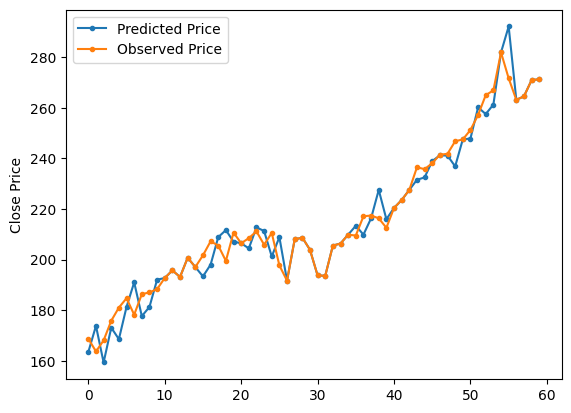

In [58]:
data = data[data.columns[1:5]]
obs = obs[obs.columns[1:5]]
# Calculate number of rows and set training window
T = data.shape[0]
print("T= ", T)

# Define the size of the training window
D = 60
hmm_price = []

temp_T = T
first_time = True

correct_predictions = 0
count = 0

# Sliding window approach to predict future prices
while T < temp_T + D:

    train_data = obs.iloc[T-D:T]
    train_data = train_data.dropna()

    if(first_time):
      first_time = False
      model = GaussianHMM(n_components=5)
    else:
      old_model= model
      model = GaussianHMM(n_components=5, init_params="c")
      model.startprob_ = old_model.startprob_
      model.transmat_ = old_model.transmat_
      model.means_ = old_model.means_

    model.fit(train_data)

    # Calculate original likelihood
    original_likelihood = model.score(train_data)

    # Loop to find most similar sequence
    t=T
    min_diff = float('inf')
    min_t = T
    min_likelihood = original_likelihood
    while t-D>  0:
        t = t-1

        train_data = obs.iloc[t-D:t]
        new_likelihood = model.score(train_data)
        if (abs(new_likelihood - original_likelihood))< min_diff: 
            min_diff = abs(new_likelihood - original_likelihood)
            min_t = t
            min_likelihood = new_likelihood

    # Calculate the predicted close price
    sign_of_change = np.sign(original_likelihood - min_likelihood)
    price_change  = obs['Close'][min_t + 1] - obs['Close'][min_t]
    predicted_change = price_change * sign_of_change
    close_price = obs['Close'][T-1] + predicted_change

    observed_change = obs['Close'][T] - obs['Close'][T - 1]
    
    # Compare the signs of predicted and observed changes
    if np.sign(predicted_change) == np.sign(observed_change):
        correct_predictions += 1

    hmm_price.append(close_price)
    T=T+1

# Print the calculated prices
print("HMM Prices: ")
print(hmm_price)

print("Correct Predictions: ", correct_predictions)

# Plot the predicted and observed prices
close = []
truncated_obs = obs.iloc[T-d:T]

for i in truncated_obs['Close']:
  close.append(i)

plt.plot(hmm_price,marker='.', label = "Predicted Price")
plt.plot(close,marker = '.', label= "Observed Price")
plt.ylabel("Close Price")
plt.legend()
plt.show()

